In [ ]:
import pandas as pd 
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr
import numpy as np
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import when
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
%fs 
ls dbfs:/FileStore/tables/Rul/

path name size modificationTime dbfs:/FileStore/tables/Rul/Battery_RUL.csv Battery_RUL.csv 1142928 1685017480000

In [ ]:
#df=pd.read_csv('/dbfs/FileStore/tables/Rul/')

In [ ]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/Rul/Battery_RUL.csv")

In [ ]:
column_mapping = {
    "Cycle_Index": "Cycle_Index",
    "Discharge Time (s)": "Discharge_Time",
    "Decrement 3.6-3.4V (s)": "Decrement",
    "Max. Voltage Dischar. (V)": "Max_Voltage_Dischar",
    "Min. Voltage Charg. (V)": "Min_Voltage_Charg",
    "Time at 4.15V (s)": "Time_atV",
    "Time constant current (s)": "Time_constant_current",
    "Charging time (s)": "Charging_Time",
    "RUL": "New_RUL"
}
# Cambio dei nomi delle colonne
for old_name, new_name in column_mapping.items():
    df = df.withColumnRenamed(old_name, new_name)

In [ ]:
cor=[]
for col1 in df.columns:
    for col2 in df.columns:
        cor.append(df.select([corr(col1,col2)]).alias(f"correlation_{col1}_{col2}").toPandas().values[0])
# Visualizza la matrice di correlazione
#print(correlation_matrix)

In [ ]:
M_corr=pd.DataFrame(np.array(cor).reshape(9,9),columns=df.columns,index=df.columns)

<AxesSubplot:>

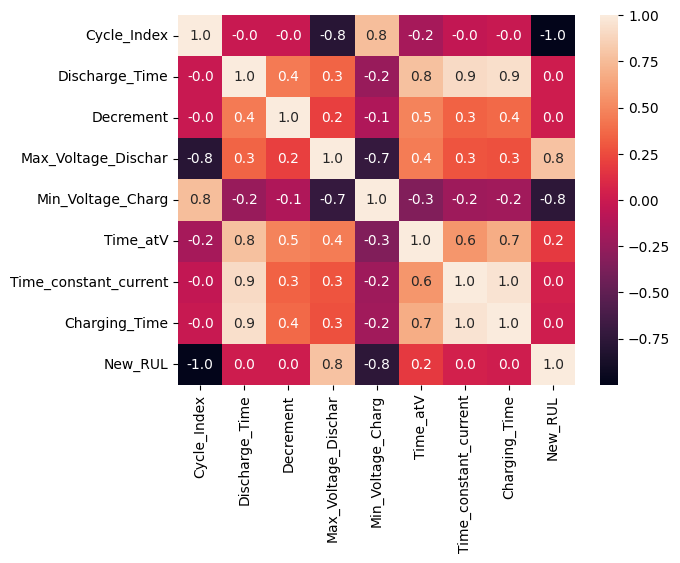

In [ ]:
sns.heatmap(M_corr,annot=True, fmt=".1f")

In [ ]:
columns=['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV']
label='New_RUL'

In [ ]:
columns_to_convert = columns

# Conversione delle colonne da stringa a float
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast("float"))
df = df.withColumn(label, col(label).cast("int"))

In [ ]:
feature_columns =  ['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV']
# Elenco delle colonne di input per il modello
label_column ='New_RUL' # Colonna di output da predire
# Crea un VectorAssembler per combinare le colonne delle features in un vettore
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#data = assembler.transform(df1).select("features", label_column)
RFR = RandomForestRegressor(featuresCol="features", 
                           labelCol=label_column, 
                           )
pipeline = Pipeline(stages=[assembler,RFR])

# Addestra il modello sulla pipeline
model = pipeline.fit(df)

In [ ]:
display(model.transform(df))

Cycle_Index Discharge_Time Decrement Max_Voltage_Dischar Min_Voltage_Charg Time_atV Time_constant_current Charging_Time New_RUL features prediction 1.0 2595.3 1151.4885 3.67 3.211 5460.001 6755.01 10777.82 1112 Map(vectorType -> dense, length -> 4, values -> List(1.0, 3.6700000762939453, 3.2109999656677246, 5460.0009765625)) 1084.7050678299913 2.0 7408.64 1172.5125000000007 4.246 3.22 5508.992 6762.02 10500.35 1111 Map(vectorType -> dense, length -> 4, values -> List(2.0, 4.245999813079834, 3.2200000286102295, 5508.9921875)) 1085.343205207295 3.0 7393.76 1112.991999999991 4.249 3.224 5508.993 6762.02 10420.38 1110 Map(vectorType -> dense, length -> 4, values -> List(3.0, 4.249000072479248, 3.2239999771118164, 5508.9931640625)) 1085.343205207295 4.0 7385.5 1080.3206666666665 4.25 3.225 5502.016 6762.02 10322.81 1109 Map(vectorType -> dense, length -> 4, values -> List(4.0, 4.25, 3.2249999046325684, 5502.01611328125)) 1085.343205207295 6.0 65022.75 29813.487 4.29 3.398 5480.992 53213.54 56699.65 1107 Map(vectorType -> dense, length -> 4, values -> List(6.0, 4.289999961853027, 3.3980000019073486, 5480.9921875)) 1078.4515353202016 7.0 3301.18 1194.2350769230688 3.674 3.504 5023.634 5977.38 5977.38 1106 Map(vectorType -> dense, length -> 4, values -> List(7.0, 3.6740000247955322, 3.503999948501587, 5023.6337890625)) 1073.8395430455573 8.0 5955.3 1220.1353285714576 4.013 3.501 5017.495 5967.55 5967.55 1105 Map(vectorType -> dense, length -> 4, values -> List(8.0, 4.013000011444092, 3.500999927520752, 5017.4951171875)) 1073.7883638536919 9.0 5951.2 1220.1353285714576 4.014 3.501 5017.496 5962.21 5962.21 1104 Map(vectorType -> dense, length -> 4, values -> List(9.0, 4.013999938964844, 3.500999927520752, 5017.49609375)) 1073.7883638536919 10.0 5945.44 1216.920914285729 4.014 3.501 5009.9937 5954.91 5954.91 1103 Map(vectorType -> dense, length -> 4, values -> List(10.0, 4.013999938964844, 3.500999927520752, 5009.99365234375)) 1073.7883638536919 11.0 435251.49 263086.078 4.267 3.086 269.984 443700.02 443700.02 1102 Map(vectorType -> dense, length -> 4, values -> List(11.0, 4.267000198364258, 3.0859999656677246, 269.9840087890625)) 949.7088632596029 12.0 3228.58 1135.3493333333172 3.689 3.485 5033.0757 5969.89 5969.89 1101 Map(vectorType -> dense, length -> 4, values -> List(12.0, 3.688999891281128, 3.484999895095825, 5033.07568359375)) 1073.8395430455573 13.0 6019.9 1058.2797241378576 4.045 3.475 5053.843 5980.77 5980.77 1100 Map(vectorType -> dense, length -> 4, values -> List(13.0, 4.045000076293945, 3.4749999046325684, 5053.8427734375)) 1073.7883638536919 14.0 6026.59 1049.487844827585 4.047 3.477 5046.4297 5966.82 5966.82 1099 Map(vectorType -> dense, length -> 4, values -> List(14.0, 4.046999931335449, 3.4769999980926514, 5046.4296875)) 1073.7883638536919 15.0 6008.07 1065.3720591132296 4.045 3.48 5033.0757 5954.47 5954.47 1098 Map(vectorType -> dense, length -> 4, values -> List(15.0, 4.045000076293945, 3.4800000190734863, 5033.07568359375)) 1073.7883638536919 16.0 423271.35 168773.265 4.27 3.108 219924.0 430028.84 430028.84 1097 Map(vectorType -> dense, length -> 4, values -> List(16.0, 4.269999980926514, 3.1080000400543213, 219924.0)) 1085.343205207295 17.0 2261.34 883.1999999999534 4.038 3.901 1949.664 2922.69 6070.11 1096 Map(vectorType -> dense, length -> 4, values -> List(17.0, 4.038000106811523, 3.9010000228881836, 1949.6639404296875)) 1023.1439746361166 18.0 2259.46 883.1990000000224 4.042 3.373 5181.377 6161.38 9310.98 1095 Map(vectorType -> dense, length -> 4, values -> List(18.0, 4.041999816894531, 3.372999906539917, 5181.376953125)) 1085.343205207295 19.0 2256.61 878.3999999999069 4.042 3.374 5181.375 6154.37 9296.64 1094 Map(vectorType -> dense, length -> 4, values -> List(19.0, 4.041999816894531, 3.374000072479248, 5181.375)) 1085.343205207295 20.0 2252.83 873.6010000000242 4.043 3.374 5174.334 6147.33 9243.58 1093 Map(vectorType -> dense, length -> 4, values -> List(20.0, 4.043000221252441, 3.374000072479248, 5174.33

In [ ]:
predictions = model.transform(df)
prediction1 =predictions.select('Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV',col("prediction").alias("p1"),when(predictions["prediction"] < 500,1).otherwise(0).alias("rul"))

In [ ]:
display(prediction1)

Cycle_Index Max_Voltage_Dischar Min_Voltage_Charg Time_atV p1 rul 1.0 3.67 3.211 5460.001 1084.7050678299913 0 2.0 4.246 3.22 5508.992 1085.343205207295 0 3.0 4.249 3.224 5508.993 1085.343205207295 0 4.0 4.25 3.225 5502.016 1085.343205207295 0 6.0 4.29 3.398 5480.992 1078.4515353202016 0 7.0 3.674 3.504 5023.634 1073.8395430455573 0 8.0 4.013 3.501 5017.495 1073.7883638536919 0 9.0 4.014 3.501 5017.496 1073.7883638536919 0 10.0 4.014 3.501 5009.9937 1073.7883638536919 0 11.0 4.267 3.086 269.984 949.7088632596029 0 12.0 3.689 3.485 5033.0757 1073.8395430455573 0 13.0 4.045 3.475 5053.843 1073.7883638536919 0 14.0 4.047 3.477 5046.4297 1073.7883638536919 0 15.0 4.045 3.48 5033.0757 1073.7883638536919 0 16.0 4.27 3.108 219924.0 1085.343205207295 0 17.0 4.038 3.901 1949.664 1023.1439746361166 0 18.0 4.042 3.373 5181.377 1085.343205207295 0 19.0 4.042 3.374 5181.375 1085.343205207295 0 20.0 4.043 3.374 5174.334 1085.343205207295 0 21.0 4.044 3.374 5160.289 1085.343205207295 0 22.0 4.044 3.375 5160.321 1085.343205207295 0 23.0 4.044 3.374 5153.414 1085.343205207295 0 24.0 4.044 3.376 5146.368 1085.343205207295 0 25.0 4.044 3.377 5139.368 1085.343205207295 0 26.0 4.044 3.377 5132.25 1085.343205207295 0 27.0 4.045 3.377 5125.344 1085.343205207295 0 28.0 4.045 3.378 5118.368 1074.0507535234556 0 29.0 4.045 3.378 5111.328 1074.0507535234556 0 30.0 4.045 3.377 5111.266 1080.942423410549 0 31.0 4.045 3.377 5104.359 1080.942423410549 0 32.0 4.045 3.378 5097.344 1074.0507535234556 0 33.0 4.045 3.377 5090.36 1080.942423410549 0 34.0 4.045 3.378 5090.312 1074.0507535234556 0 35.0 4.045 3.379 5083.359 1074.0507535234556 0 36.0 4.046 3.378 5076.266 1060.7400087751562 0 37.0 4.046 3.378 5076.344 1060.7400087751562 0 38.0 4.046 3.393 5069.313 1060.7400087751562 0 39.0 4.046 3.379 5062.375 1060.7400087751562 0 40.0 4.025 3.604 5026.312 1060.4776191053927 0 41.0 4.041 3.686 5020.312 1060.4776191053927 0 42.0 4.045 3.382 5058.797 1060.7400087751562 0 43.0 4.045 3.379 5069.375 1060.7400087751562 0 44.0 4.045 3.379 5062.375 1060.7400087751562 0 45.0 4.045 3.381 5048.343 1060.7400087751562 0 46.0 4.044 3.381 5041.25 1060.7400087751562 0 47.0 4.045 3.381 5034.375 1060.7400087751562 0 48.0 4.045 3.382 5030.734 1060.7400087751562 0 49.0 4.045 3.382 5027.281 1060.7400087751562 0 50.0 4.045 3.383 5020.375 1060.7400087751562 0 51.0 4.045 3.384 5013.375 1060.7400087751562 0 52.0 4.044 3.386 5006.344 1060.7400087751562 0 53.0 4.044 3.385 4999.219 1060.7400087751562 0 54.0 4.044 3.387 4992.25 1060.7400087751562 0 55.0 4.044 3.387 4988.8594 1060.7400087751562 0 56.0 4.044 3.387 4985.344 1060.7400087751562 0 57.0 4.044 3.388 4978.281 1060.7400087751562 0 58.0 4.044 3.387 4978.313 1060.7400087751562 0 59.0 4.044 3.388 4971.375 1060.7400087751562 0 60.0 4.044 3.389 4964.313 1050.7694252881813 0 61.0 4.043 3.391 4960.8433 1050.7694252881813 0 62.0 4.043 3.39 4957.375 1050.7694252881813 0 63.0 4.043 3.39 4957.375 1050.7694252881813 0 64.0 4.022 3.625 4921.375 1050.5070356184176 0 65.0 4.271 3.166 72809.984 1072.0324604589955 0 66.0 4.004 3.381 5213.92 1057.7621694768973 0 67.0 4.007 3.395 4969.152 1053.3613876801514 0 68.0 4.007 3.394 4969.178 1053.3613876801514 0 69.0 4.008 3.394 4961.92 1045.0288210262538 0 70.0 4.007 3.395 4954.783 1045.0288210262538 0 71.0 4.008 3.398 4947.551 1026.5019629346734 0 72.0 4.008 3.397 4940.32 1026.5019629346734 0 73.0 4.008 3.399 4933.121 1026.5019629346734 0 74.0 4.008 3.399 4928.32 1026.5019629346734 0 75.0 4.008 3.401 4918.791 1026.5019629346734 0 76.0 4.008 3.401 4916.321 1026.5019629346734 0 77.0 4.008 3.401 4911.551 1026.5019629346734 0 78.0 4.008 3.401 4910.359 1026.5019629346734 0 79.0 4.007 3.402 4904.328 1026.5019629346734 0 80.0 4.008 3.402 4897.159 1026.5019629346734 0 81.0 4.008 3.403 4889.913 1026.5019629346734 0 82.0 4.008 3.405 4882.728 1026.5019629346734 0 83.0 4.008 3.403 4880.343 1026.5019629346734 0 84.0 4.008 3.404 4875.513 1026.5019629346734 0 85.0 4.008 3.404 4868.328 1026.5019629346734 0 86.0 4.008 3.405 4868.

In [ ]:
train, test = prediction1.randomSplit([0.7, 0.3], seed=42)

In [ ]:
feature_columns =  ['Cycle_Index',
 'Max_Voltage_Dischar',
 'Min_Voltage_Charg',
 'Time_atV',"p1"]
# Elenco delle colonne di input per il modello
label_column = "rul" # Colonna di output da predire
# Crea un VectorAssembler per combinare le colonne delle features in un vettore
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#data = assembler.transform(df1).select("features", label_column)
RFC = RandomForestClassifier(featuresCol="features", 
                           labelCol=label_column, 
                           )
pipeline = Pipeline(stages=[assembler,RFC])

# Addestra il modello sulla pipeline
model2= pipeline.fit(train)

In [ ]:
prediction = model2.transform(train)

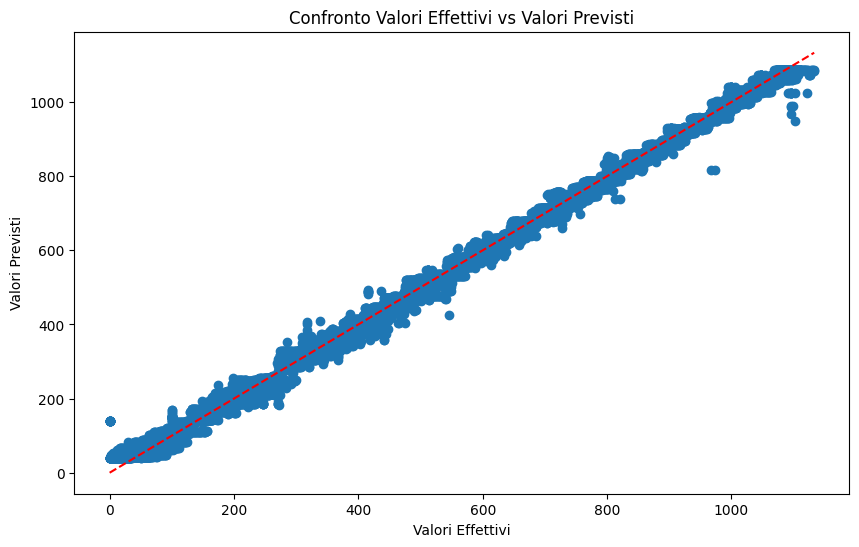

In [ ]:

# Ottenere i valori previsti e i valori effettivi dal DataFrame delle predizioni
predicted_values = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()
actual_values = predictions.select('New_RUL').rdd.map(lambda row: row[0]).collect()

# Creare il grafico di confronto
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.xlabel("Valori Effettivi")
plt.ylabel("Valori Previsti")
plt.title("Confronto Valori Effettivi vs Valori Previsti")
plt.show()

In [ ]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Crea un oggetto BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="rul")

# Calcola l'area sotto la curva ROC (AUC)
auc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC Curve (AUC):", auc)


Area Under ROC Curve (AUC): 0.9999738285144567
